In [1]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [12]:
with open("../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/pseudosequence2idx.json", "r") as f:
    seq2idx = json.load(f)
idx2seq = {i:s for s, i in seq2idx.items()}

In [13]:
mapping = pd.read_csv("../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseq_mapping.csv")
mapping

,HLA,sequence
0,HLA-A01:01,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY
1,HLA-A01:02,YSAMYQENMAHTDANTLYIIYRDYTWVARVYRGY
2,HLA-A01:03,YFAMYQENMAHTDANTLYIMYRDYTWVARVYRGY
3,HLA-A01:06,YFAMYQENMAHTDANTLYIIYRDYTWVALAYRGY
4,HLA-A01:07,YFAMYQENVAHTDENTLYIIYRDYTWVARVYRGY
...,...,...
3717,BoLA-6:01501,YYTKYREISENWYEANLYLLYTFYSMADQNYRGY
3718,BoLA-6:01502,YYTKYREISENWYEANLYLQFTFYSMADQNYRGY
3719,BoLA-6:03401,YHTKYREISENVYGSNLYLLYTFYSMADRNYRGY
3720,BoLA-6:04001,YSEMYEERAGIVFVNTLYLWCWFYSMAAGKYTWY


In [14]:
hla2seq = dict(zip(mapping["HLA"], mapping["sequence"]))
# hla2seq

In [15]:
embeddings = np.load("../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseqs_T5_embeddings.npy")
embeddings.shape

(2113, 1024)

In [23]:
class Pretrained_HLA_Embedder(nn.Module):
    def __init__(self, seq2idx_file=None, embeddings_file=None, device="cpu"):
        super().__init__()
        with open(seq2idx_file, "r") as f:
            self.seq2idx = json.load(f)
        self.idx2seq = {i:s for s, i in self.seq2idx.items()}
        self.device = device
        embeddings = np.load(embeddings_file)
        self.pretrained_embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings, device=self.device))
        # self.self.pretrained_embeddings.to(device)
    
    def forward(self, hla_seqs):
        idxs = [self.seq2idx[s] for s in hla_seqs]
        idxs_tensor = torch.LongTensor(idxs, device=self.device)
        embs = self.pretrained_embeddings(idxs_tensor)
        return embs

In [24]:
embedder = Pretrained_HLA_Embedder(seq2idx_file="../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/pseudosequence2idx.json",
                                   embeddings_file="../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseqs_T5_embeddings.npy")

In [26]:
test_seqs = mapping["sequence"].iloc[:6].values
test_seqs

array(['YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY',
       'YSAMYQENMAHTDANTLYIIYRDYTWVARVYRGY',
       'YFAMYQENMAHTDANTLYIMYRDYTWVARVYRGY',
       'YFAMYQENMAHTDANTLYIIYRDYTWVALAYRGY',
       'YFAMYQENVAHTDENTLYIIYRDYTWVARVYRGY',
       'YFAMYQENMAHTDANTLYIIYRDYTWVARVYWGY'], dtype=object)

In [28]:
embedder(test_seqs).shape

torch.Size([6, 1024])

In [29]:
embedder2 = Pretrained_HLA_Embedder(seq2idx_file="../processed_data/HLA_embeddings/HLA_proteins_T5/prot_sequence2idx.json",
                                   embeddings_file="../processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_T5_embeddings.npy")

In [30]:
mapping2 = pd.read_csv("../processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv")
mapping2

,HLA_id,HLA,Bp,sequence
0,HLA:HLA00001,HLA-A01:01:01:01,365,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
1,HLA:HLA02169,HLA-A01:01:01:02N,200,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
2,HLA:HLA14798,HLA-A01:01:01:03,365,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
3,HLA:HLA15760,HLA-A01:01:01:04,365,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
4,HLA:HLA16415,HLA-A01:01:01:05,365,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
...,...,...,...,...
25295,HLA:HLA00344,HLA-B51:01,362,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
25296,HLA:HLA00467,HLA-C15:02,366,MRVMAPRTLLLLLSGALALTETWACSHSMRYFYTAVSRPGRGEPHF...
25297,HLA:HLA00294,HLA-B40:03,362,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...
25298,HLA:HLA00410,HLA-C03:02,366,MRVMAPRTLILLLSGALALTETWAGSHSMRYFYTAVSRPGRGEPHF...


In [31]:
test_seqs2 = mapping2["sequence"].iloc[:6].values
test_seqs2

array(['MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWELSSQPTIPIVGIIAGLVLLGAVITGAVVAAVMWRRKSSDRKGGSYTQAASSDSAQGSDVSLTACKV',
       'MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGDPGPGRRSRPLIPHGRARSPTVSGSEIHPEAAGLRDPCPGRGPGAFTRFHFQFRPKIPPGWSGRGGARGTGLTAGSGPGSHTIQX',
       'MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWELSSQPTIPIVGIIAGLVLLGAVITGAVVAAVMWRRKSSDRKGGSYTQAASSDSAQGSDVSLTACKV',
       'MAVMAPRTLLLLLSGALALTQTWAGSHSM

In [32]:
embedder2(test_seqs2)

tensor([[ 0.0252,  0.1471,  0.0348,  ..., -0.0539,  0.0308,  0.0502],
        [ 0.0189,  0.0803,  0.0627,  ..., -0.0234,  0.0157,  0.0798],
        [ 0.0252,  0.1471,  0.0348,  ..., -0.0539,  0.0308,  0.0502],
        [ 0.0252,  0.1471,  0.0348,  ..., -0.0539,  0.0308,  0.0502],
        [ 0.0252,  0.1471,  0.0348,  ..., -0.0539,  0.0308,  0.0502],
        [ 0.0252,  0.1471,  0.0348,  ..., -0.0539,  0.0308,  0.0502]])

In [39]:

class Pretrained_HLA_Embedder(nn.Module):
    def __init__(self, config, device="cpu", prefix=""):
        super().__init__()
        with open(config[prefix+"seq2idx_file"], "r") as f:
            self.seq2idx = json.load(f)
        self.idx2seq = {i:s for s, i in self.seq2idx.items()}
        self.device = device
        embeddings = np.load(config[prefix+"embeddings_file"])
        self.pretrained_embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings, device=self.device))
        self.pretrained_embeddings.to(device)
    
    def forward(self, hla_seqs):
        idxs = [self.seq2idx[s] for s in hla_seqs]
        idxs_tensor = torch.LongTensor(idxs, device=self.device)
        embs = self.pretrained_embeddings(idxs_tensor)
        return embs
    
    
class Joint_HLA_Embedder(nn.Module):
    def __init__(self, config, device="cpu"):
        super().__init__()
        self.pseudoseq_embedder = Pretrained_HLA_Embedder(config, device=device, prefix="pseudoseq_")
        self.protein_embedder = Pretrained_HLA_Embedder(config, device=device, prefix="protein_")
        
    def forward(self, hla_pseudoseqs, hla_protein_seqs):
        pseq_embs = self.pseudoseq_embedder(hla_pseudoseqs)
        prot_embs = self.protein_embedder(hla_protein_seqs)
        joint_embs = torch.cat([pseq_embs, prot_embs], dim=1)
        return joint_embs

In [2]:
config = {"pseudoseq_seq2idx_file": "../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/pseudosequence2idx.json",
    "pseudoseq_embeddings_file": "../processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseqs_T5_embeddings.npy",
          "protein_seq2idx_file": "../processed_data/HLA_embeddings/HLA_proteins_T5/prot_sequence2idx.json",
        "protein_embeddings_file": "../processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_T5_embeddings.npy"
}

In [41]:
emb = Joint_HLA_Embedder(config)

In [42]:
joint_embs = emb(test_seqs, test_seqs2)

In [43]:
joint_embs.shape

torch.Size([6, 2048])

In [20]:


def load_binding_affinity_dataframes_jointseqs(config, split_data=True):
    ps_df = pd.read_csv(config['pseudo_seq_file'])
    prot_df = pd.read_csv(config['hla_prot_seq_file'])


    hla_pseq_mapping = dict(ps_df[["HLA", "sequence"]].values)
    hla_prot_mapping = dict(prot_df[["HLA", "sequence"]].values)
    hla_prot_mapping
    ba_df = pd.read_csv(config['binding_affinity_df'])
    ba_df["Allele Pseudo-sequence"] = ba_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
    ba_df["Allele Protein sequence"] = ba_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)
    ba_df = ba_df.dropna().reset_index(drop=True)
    ba_df = filter_peptide_dataset(ba_df, sorted_vocabulary)
    ba_df = ba_df[["HLA", "Peptide", "Label", "Allele Pseudo-sequence", "Allele Protein sequence"]]
    
    ligand_atlas_binding_df = pd.read_csv(config["ligand_atlas_binding_df"])
    ligand_atlas_binding_df["Allele Pseudo-sequence"] = ligand_atlas_binding_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
    ligand_atlas_binding_df["Allele Protein sequence"] = ligand_atlas_binding_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)
    ligand_atlas_binding_df = ligand_atlas_binding_df.dropna().reset_index(drop=True)
    ligand_atlas_binding_df = filter_peptide_dataset(ligand_atlas_binding_df, sorted_vocabulary)

    # Filter to remove duplicate samples 
    dhlap_samples = set(tuple(x) for x in ba_df[["Peptide", "HLA"]].values)
    la_samples = set(tuple(x) for x in ligand_atlas_binding_df[["Peptide", "HLA"]].values)
    ligand_atlas_binding_df = ligand_atlas_binding_df[ligand_atlas_binding_df[["Peptide", "HLA"]].apply(tuple, 1).isin(la_samples.difference(dhlap_samples))]
    
    ba_df = pd.concat([ba_df, ligand_atlas_binding_df])
    
    # ba_df
    ba_df["Stratification_index"] = ba_df["HLA"] + "_" + ba_df["Label"].astype(str)
    if not split_data:
        return ba_df

    ix = ba_df["Stratification_index"].value_counts()
    low_count_labels = ix[ix<3].index
    res_df = ba_df[ba_df["Stratification_index"].isin(low_count_labels)]
    ba_df = ba_df[~ba_df["Stratification_index"].isin(low_count_labels)]


    trainval_ba_df, test_ba_df = train_test_split(ba_df, test_size=config["test_size"], stratify=ba_df["Stratification_index"], random_state=config['seed'], shuffle=True)
    train_ba_df, val_ba_df = train_test_split(trainval_ba_df, test_size=config["val_size"], stratify=trainval_ba_df["Stratification_index"], random_state=config['seed'], shuffle=True)
    if res_df is not None:
        train_ba_df = pd.concat([train_ba_df, res_df])

    return train_ba_df, val_ba_df, test_ba_df

In [9]:

from sklearn.model_selection import train_test_split
from selfpeptide.utils.constants import *
from selfpeptide.utils.function_utils import *

def filter_peptide_dataset(df, vocabulary, label="Peptide"):
    aa_vocab = set(vocabulary)
    
    ix_to_keep = []
    
    for i, t in enumerate(df.itertuples()):
        if len(set(getattr(t, label)).difference(aa_vocab))==0:
            ix_to_keep.append(i)
    return df.iloc[ix_to_keep]
    
    


In [19]:
config_load = {
 "pseudo_seq_file": "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseq_mapping.csv",
    "hla_prot_seq_file": "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv",
    "binding_affinity_df": "/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv",
    "ligand_atlas_binding_df": "/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/HLA_Ligand_Atlas_processed.csv",
    "seed": 0,
    "test_size": 0.15,
    "val_size": 0.1
}
split_data = True
config= config_load
ps_df = pd.read_csv(config['pseudo_seq_file'])
prot_df = pd.read_csv(config['hla_prot_seq_file'])


hla_pseq_mapping = dict(ps_df[["HLA", "sequence"]].values)
hla_prot_mapping = dict(prot_df[["HLA", "sequence"]].values)
hla_prot_mapping
ba_df = pd.read_csv(config['binding_affinity_df'])
ba_df["Allele Pseudo-sequence"] = ba_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
ba_df["Allele Protein sequence"] = ba_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)
ba_df = ba_df.dropna().reset_index(drop=True)
ba_df = filter_peptide_dataset(ba_df, sorted_vocabulary)
ba_df = ba_df[["HLA", "Peptide", "Label", "Allele Pseudo-sequence", "Allele Protein sequence"]]


ligand_atlas_binding_df = config.get("ligand_atlas_binding_df", None)
if ligand_atlas_binding_df is not None:
    ligand_atlas_binding_df = pd.read_csv(ligand_atlas_binding_df)
    ligand_atlas_binding_df["Allele Pseudo-sequence"] = ligand_atlas_binding_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
    ligand_atlas_binding_df["Allele Protein sequence"] = ligand_atlas_binding_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)
    ligand_atlas_binding_df = ligand_atlas_binding_df.dropna().reset_index(drop=True)
    ligand_atlas_binding_df = filter_peptide_dataset(ligand_atlas_binding_df, sorted_vocabulary)

# ba_df
ba_df["Stratification_index"] = ba_df["HLA"] + "_" + ba_df["Label"].astype(str)
# if not split_data:
#     return ba_df, ligand_atlas_binding_df

ix = ba_df["Stratification_index"].value_counts()
low_count_labels = ix[ix<3].index
res_df = ba_df[ba_df["Stratification_index"].isin(low_count_labels)]
ba_df = ba_df[~ba_df["Stratification_index"].isin(low_count_labels)]


trainval_ba_df, test_ba_df = train_test_split(ba_df, test_size=config["test_size"], stratify=ba_df["Stratification_index"], random_state=config['seed'], shuffle=True)
train_ba_df, val_ba_df = train_test_split(trainval_ba_df, test_size=config["val_size"], stratify=trainval_ba_df["Stratification_index"], random_state=config['seed'], shuffle=True)
if res_df is not None:
    train_ba_df = pd.concat([train_ba_df, res_df])

# return train_ba_df, val_ba_df, test_ba_df, ligand_atlas_binding_df

SyntaxError: unterminated string literal (detected at line 24) (1732731730.py, line 24)

In [11]:
train_ba_df

,HLA,Peptide,Method,Measurement,Type,Affinity(nM),Label,Allele Pseudo-sequence,Allele Protein sequence,Stratification_index
230187,HLA-B44:02,GEVNSRPTY,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B44:02_1
193606,HLA-B27:09,RRWKAGLYGL,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YHTEYREICAKTDEDTLYLNYHHYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B27:09_1
304531,HLA-A29:02,VTFPEFLRY,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YTAMYLQNVAQTDANTLYIMYRDYTWAVLAYTWY,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,HLA-A29:02_1
314263,HLA-B08:01,DAKTKAQL,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFDTAMSRPGRGEPRF...,HLA-B08:01_1
115557,HLA-A02:01,GYMFESKSM,purified MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,HLA-A02:01_0
...,...,...,...,...,...,...,...,...,...,...
125124,HLA-A02:09,YLEPAIAKY,cellular MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,HLA-A02:09_0
207555,HLA-C07:04,AIMESGVAL,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YDSGYREKYRQADVSNLYFRYDFYTLAADAYTWY,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...,HLA-C07:04_1
265161,HLA-B50:02,NEIKDSVVA,cellular MHC/mass spectrometry,ligand presentation,Positive,0.0,1,YHTKYREISTNTYESNLYWRYNLYTWAELAYLSY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,HLA-B50:02_1
308960,HLA-A02:08,YLEPAIAKY,cellular MHC/direct/fluorescence,qualitative binding,Positive,0.0,1,YYAMYGENVAHTHVDTLYLRYHYYTWAVWAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,HLA-A02:08_1


In [12]:
ligand_atlas_binding_df

,Peptide,HLA,Label,Allele Pseudo-sequence,Allele Protein sequence
0,KLFNEHIEAL,HLA-A11:01,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
1,KLFNEHIEAL,HLA-B40:02,0,YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...
2,KLFNEHIEAL,HLA-B58:01,0,YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
3,KLFNEHIEAL,HLA-C02:02,0,YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY,MRVMAPRTLLLLLSGALALTETWACSHSMRYFYTAVSRPSRGEPHF...
4,KLFNEHIEAL,HLA-C07:01,0,YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...
...,...,...,...,...,...
724635,IAVDVTSAL,HLA-A11:01,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
724636,IAVDVTSAL,HLA-B15:01,0,YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...
724637,IAVDVTSAL,HLA-B35:01,1,YYATYRNIFTNTYESNLYIRYDSYTWAVLAYLWY,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
724638,IAVDVTSAL,HLA-C03:03,1,YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY,MRVMAPRTLILLLSGALALTETWAGSHSMRYFYTAVSRPGRGEPHF...


In [13]:
# from selfpeptide.utils.data_utils import load_binding_affinity_dataframes_jointseqs

In [21]:
train_ba_df, val_ba_df, test_ba_df = load_binding_affinity_dataframes_jointseqs(config)

In [26]:
train_ba_df["Label"].mean()

0.4273281169748536

In [27]:
train_ba_df

,HLA,Peptide,Label,Allele Pseudo-sequence,Allele Protein sequence,Stratification_index
256796,HLA-B54:01,LLFHNAVSA,1,YYAGYRNIYAQTDESNLYWTYNLYTWAVLAYTWY,MRVTAPRTLLLLLWGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B54:01_1
594949,HLA-A24:02,HATESEHSL,0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,HLA-A24:02_0
265642,HLA-B39:01,NHFMDNTTL,1,YYSEYRNICTNTDESNLYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,HLA-B39:01_1
129493,HLA-A32:01,VFQKQASM,0,YFAMYQENVAHTDESIAYIMYQDYTWAVLAYTWY,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,HLA-A32:01_0
319007,HLA-B15:01,NVAEINRQV,0,YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B15:01_0
...,...,...,...,...,...,...
123558,HLA-B27:09,VAFTSHEHF,0,YHTEYREICAKTDEDTLYLNYHHYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B27:09_0
125124,HLA-A02:09,YLEPAIAKY,0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,HLA-A02:09_0
265161,HLA-B50:02,NEIKDSVVA,1,YHTKYREISTNTYESNLYWRYNLYTWAELAYLSY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,HLA-B50:02_1
308960,HLA-A02:08,YLEPAIAKY,1,YYAMYGENVAHTHVDTLYLRYHYYTWAVWAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,HLA-A02:08_1


In [96]:
dhlap_samples = set(tuple(x) for x in train_ba_df[["Peptide", "HLA"]].values).union(set(tuple(x) for x in val_ba_df[["Peptide", "HLA"]].values))
la_samples = set(tuple(x) for x in ligand_atlas_binding_df[["Peptide", "HLA"]].values)
ligand_atlas_binding_df = ligand_atlas_binding_df[ligand_atlas_binding_df[["Peptide", "HLA"]].apply(tuple, 1).isin(la_samples.difference(dhlap_samples))]
ligand_atlas_binding_df

,Peptide,HLA,Label,Allele Pseudo-sequence,Allele Protein sequence
0,KLFNEHIEAL,HLA-A11:01,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
1,KLFNEHIEAL,HLA-B40:02,0,YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...
2,KLFNEHIEAL,HLA-B58:01,0,YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
3,KLFNEHIEAL,HLA-C02:02,0,YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY,MRVMAPRTLLLLLSGALALTETWACSHSMRYFYTAVSRPSRGEPHF...
4,KLFNEHIEAL,HLA-C07:01,0,YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...
...,...,...,...,...,...
724635,IAVDVTSAL,HLA-A11:01,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
724636,IAVDVTSAL,HLA-B15:01,0,YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...
724637,IAVDVTSAL,HLA-B35:01,1,YYATYRNIFTNTYESNLYIRYDSYTWAVLAYLWY,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
724638,IAVDVTSAL,HLA-C03:03,1,YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY,MRVMAPRTLILLLSGALALTETWAGSHSMRYFYTAVSRPGRGEPHF...


In [73]:
class SequencesInteractionDataset(Dataset):
    def __init__(self, df, hla_repr=["Allele Pseudo-sequence", "Allele Protein sequence"], target_label="Label"):        
        super().__init__()
        cols = ["Peptide", *hla_repr, target_label]
        self.data_matrix = df[cols].values.tolist()
    
    def __len__(self):
        return len(self.data_matrix)
    
    def __getitem__(self, ix):
        return self.data_matrix[ix]
    
dset = SequencesInteractionDataset(train_ba_df)
dset[0]

['GEVNSRPTY',
 'YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY',
 'MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKEPRAPWIEQEGPEYWDRETQISKTNTQTYRENLRTALRYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQDAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQDRAYLEGLCVESLRRYLENGKETLQRADPPKTHVTHHPISDHEVTLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDRTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWEPSSQSTVPIVGIVAGLAVLAVVVIGAVVAAVMCRRKSSGGKGGSYSQAACSDSAQGSDVSLTA',
 1]

In [74]:
sigmoid

NameError: name 'sigmoid' is not defined

In [75]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
a = 0.2
print(sigmoid(a))
neg_a = 1-sigmoid(a)
print(neg_a)
neg_logit = np.log(neg_a/(1-neg_a))
print(neg_logit)

0.549833997312478
0.45016600268752205
-0.20000000000000018


In [92]:
pos_logits = np.linspace(-2,2, 100)
pos_probs = sigmoid(pos_logits)
neg_probs = 1-pos_probs
neg_logits = np.log(neg_probs/(1-neg_probs))


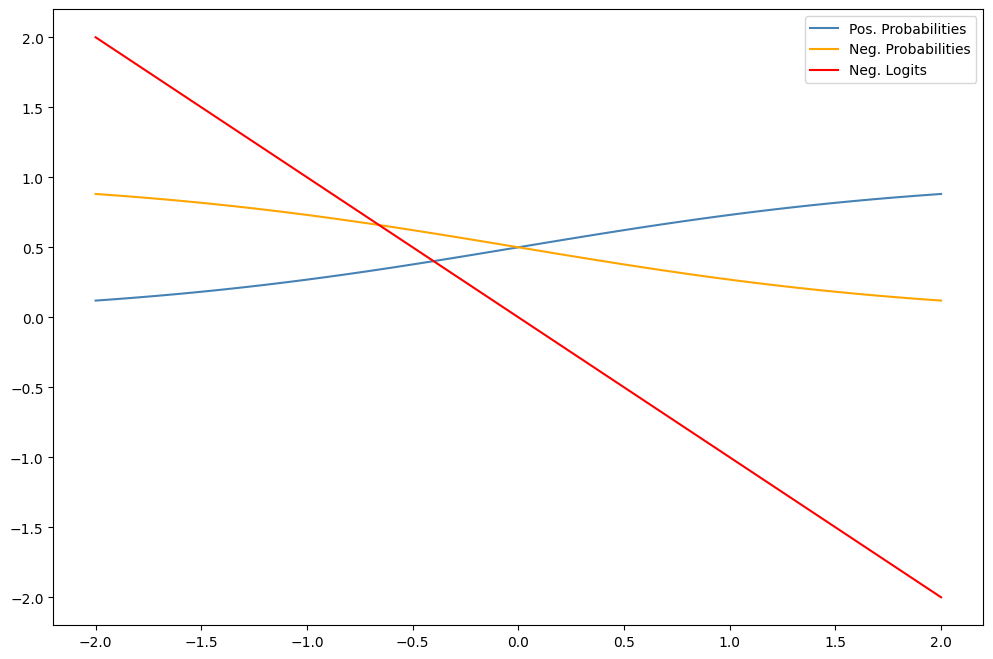

In [93]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pos_logits, pos_probs, color="steelblue", label="Pos. Probabilities")
ax.plot(pos_logits, neg_probs, color="orange", label="Neg. Probabilities")
ax.plot(pos_logits, neg_logits, color="red", label="Neg. Logits")



ax.legend()
plt.show()